# Plot Metrics vs Distributional features with Confidence Intervals

This notebook creates a plot showing curves for each metric with confidence intervals, where:
- x-axis: bhvr_rate (behavior rate)
- y-axis: metric values with confidence intervals
- Each metric is shown as a separate curve with shaded confidence intervals
- Legend shows the metric names instead of text on the plot

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms
import os
import json

# options to make text editable in illustrator
plt.style.use("stylesheet.mplstyle")
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

In [4]:
# Function to calculate confidence intervals
def get_ci(a):
    return sms.DescrStatsW(a).tconfint_mean()


# homophily in the original data is from 0 to 0.9. We need to rescale so homophily is between -1 and 1,
def rescale(values):
    return values * 2 - 1

## Define subplot names and metric names

In [5]:
result_dirs = ["user_pol", "iu_var", "note_pol", "homophily"]

# import metrics, metric_names, and exp_to_y_axis_names from a global definition
metrics = json.load(open("definitions.json"))["metrics"]
metric_names = json.load(open("definitions.json"))["metric_names"]
exp_to_y_axis_names = json.load(open("definitions.json"))["exp_to_y_axis_names"]
ax_labels = json.load(open("definitions.json"))["ax_labels"]

## Read data

In [ ]:
helpfulness = "helpfulness_True"
condition = "all"
data = {}
for result_dir in result_dirs:
    print(f" ** {result_dir} **")
    # Load data
    metric_fpath = f"{result_dir}/FP_count/{helpfulness}.csv"
    if not os.path.exists(metric_fpath):
        print(f"File {metric_fpath} does not exist")
        data[result_dir] = None
        continue

    df = pd.read_csv(metric_fpath)
    df = df[df["condition"] == condition]
    print(" shape", df.shape)
    df = df.drop_duplicates(subset=["condition", "params"])
    print(" shape after dropping duplicates", df.shape)
    # Group by y values, compute mean and CI for each metric
    agg_funcs = {"params": ("params", "count")}  # count the number of observations
    for m in metrics:
        agg_funcs[m + "_mean"] = (m, "mean")
        agg_funcs[m + "_ci_lower"] = (m, lambda x: get_ci(x.values)[0])
        agg_funcs[m + "_ci_upper"] = (m, lambda x: get_ci(x.values)[1])

    y_axis_name = exp_to_y_axis_names[
        result_dir
    ]  # decide which column to group by, based on the exp_to_y_axis_names dict
    df_summary = df.groupby(y_axis_name).agg(**agg_funcs).reset_index()
    df_summary = df_summary.rename(columns={"params": "no_observations"})
    if result_dir == "homophily":
        df_summary[y_axis_name] = df_summary[y_axis_name].apply(lambda x: rescale(x))
        print(" * Rescaled homophily values: ", df_summary[y_axis_name].unique())
    # Sanity check
    print("  * Unique y values: ", df_summary[y_axis_name].unique())
    print(
        f"    No. observations per y value: {df_summary['no_observations'].describe()['mean']} pm {df_summary['no_observations'].describe()['std']}"
    )
    print(f"    Available columns: {df_summary.columns.tolist()}\n")

    data[result_dir] = df_summary

 ** user_pol **


 shape (549, 15)
 shape after dropping duplicates (549, 15)
  * Unique y values:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
    No. observations per y value: 49.90909090909091 pm 0.30151134457776363
    Available columns: ['mu_fur', 'no_observations', 'p_h_U_mean', 'p_h_U_ci_lower', 'p_h_U_ci_upper', 'p_u_H_mean', 'p_u_H_ci_lower', 'p_u_H_ci_upper', 'p_H_u_mean', 'p_H_u_ci_lower', 'p_H_u_ci_upper', 'p_U_h_mean', 'p_U_h_ci_lower', 'p_U_h_ci_upper']

 ** iu_var **
 shape (500, 15)
 shape after dropping duplicates (500, 15)
  * Unique y values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
    No. observations per y value: 50.0 pm 0.0
    Available columns: ['var_iu', 'no_observations', 'p_h_U_mean', 'p_h_U_ci_lower', 'p_h_U_ci_upper', 'p_u_H_mean', 'p_u_H_ci_lower', 'p_u_H_ci_upper', 'p_H_u_mean', 'p_H_u_ci_lower', 'p_H_u_ci_upper', 'p_U_h_mean', 'p_U_h_ci_lower', 'p_U_h_ci_upper']

 ** note_pol **
 shape (550, 15)
 shape after dropping duplicates (550, 15)
  * Unique y values:  [0.  0.

In [ ]:
def format_integer_ticks(x, pos):
    if x != 0 and x != 1 and x != -1:
        return f"{x:.1f}"
    else:
        return f"{int(x)}"


def plot_data(df_summary, ax, names, metrics, x_label, x_col_name, legend_true=False):
    """
    For an experiment type, plot a curve for each metric with confidence intervals
    """
    colors = ["#6F6F6F", "#DC267F", "#FE6100", "#0047FF"]  # black, pink, orange, blue
    # Plot each metric
    for i, metric in enumerate(metrics):
        # Get the data for this metric
        x = df_summary[x_col_name]
        y_mean = df_summary[f"{metric}_mean"]
        y_lower = df_summary[f"{metric}_ci_lower"]
        y_upper = df_summary[f"{metric}_ci_upper"]
        yerr = [y_mean - y_lower, y_upper - y_mean]

        # Scatter + error bars
        ax.errorbar(
            x,
            y_mean,
            yerr=yerr,
            fmt="o",
            markersize=10,
            capsize=10,
            color=colors[i],
            label=names[metric],
        )
    ax.set_ylim(0, 1)
    # Customize the plot
    ax.set_xlabel(x_label)
    if legend_true:
        ax.legend(fontsize=15, loc="upper left", frameon=False)

    # Custom formatting
    import matplotlib.ticker as mticker

    ax.tick_params(direction="in")

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))

## Plot

2 2
0, user_pol
1, iu_var
2, note_pol
3, homophily


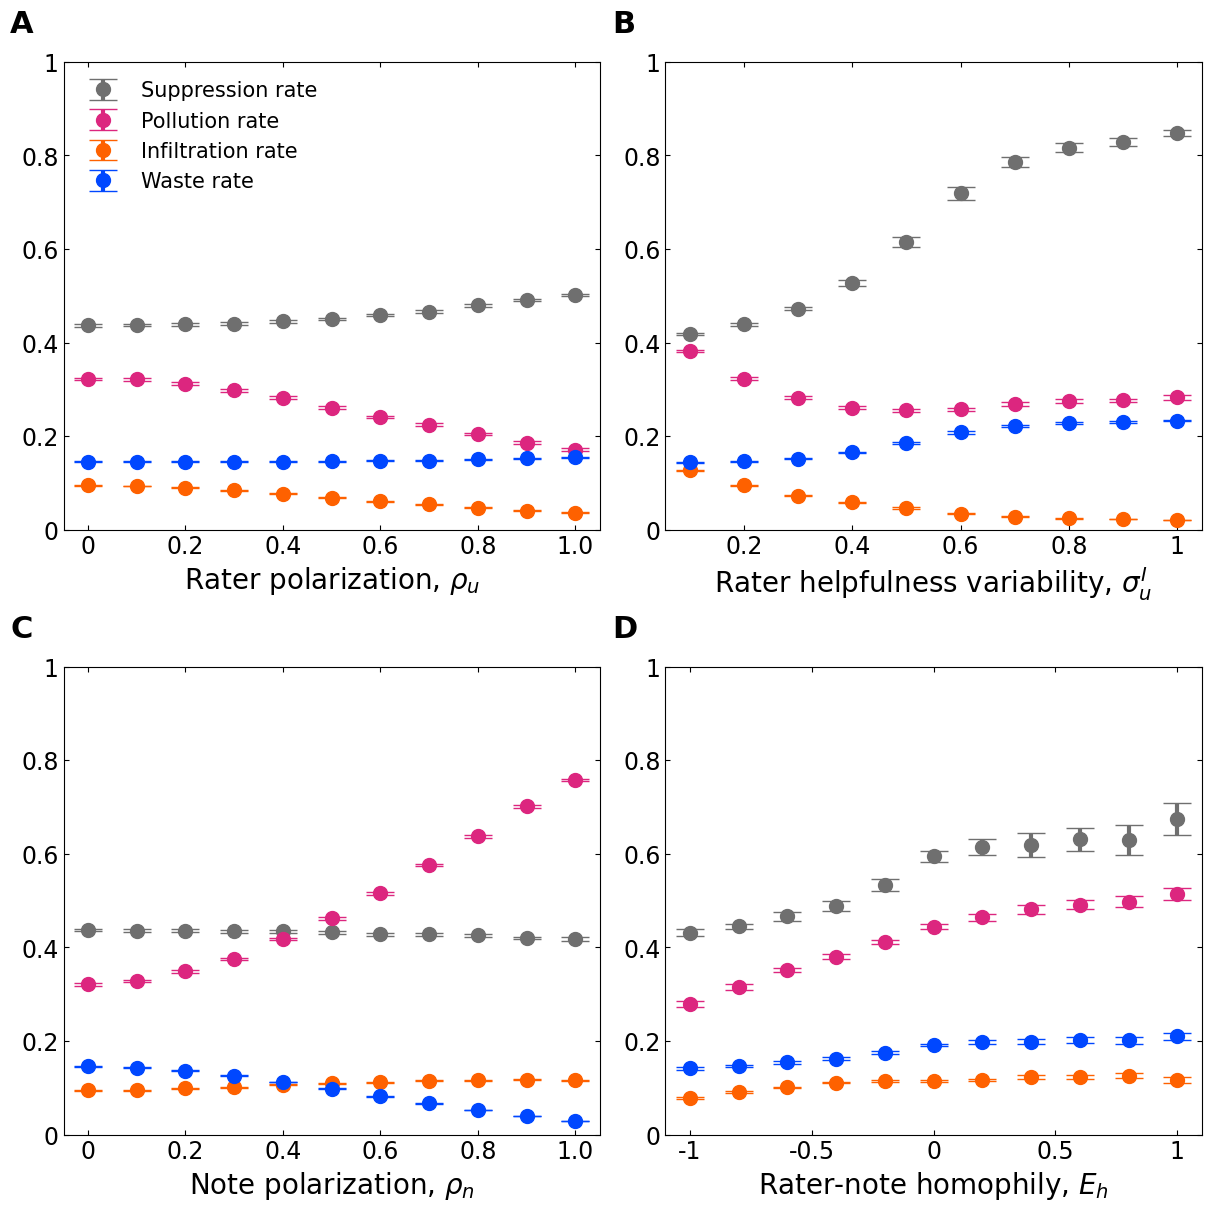

In [9]:
FIG_NAME = "Fig1."


# Plot each data (item) in data in a subplot with 2 column and number of rows to be decided by the number of items in data
import math

num_rows = math.floor(len(data) / 2) + len(data) % 2
num_cols = 2
print(num_rows, num_cols)
fig, axs = plt.subplots(
    num_rows, num_cols, figsize=(6 * num_rows, 6 * num_cols), constrained_layout=True
)


flat_axs = axs.flatten()
for i, (result_dir, df_summary) in enumerate(data.items()):
    x_col_name = exp_to_y_axis_names[result_dir]
    x_label = ax_labels[x_col_name]

    # Add subplot labels (A, B, C, D) outside the subplot area
    subplot_labels = ["A", "B", "C", "D"]
    print(f"{i}, {result_dir}")
    ax = flat_axs[i]
    ax.text(
        -0.1,
        1.05,
        subplot_labels[i],
        transform=ax.transAxes,
        fontsize=22,
        fontweight="bold",
        va="bottom",
        ha="left",
        bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0),
    )
    if i == 0:
        legend_true = True
    else:
        legend_true = False
    if df_summary is None:
        # plot an empty subplot
        ax.set_xlabel(x_label)
        ax.tick_params(direction="in")
        continue
    else:
        plot_data(
            df_summary,
            ax,
            metric_names,
            metrics,
            x_label,
            x_col_name,
            legend_true=legend_true,
        )

# Enable y-axis tick labels on the right
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.top"] = True
# Current working directory (where notebook is running)
cwd = os.getcwd()
plot_dir = "plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# Save outputs
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.pdf", dpi=300, bbox_inches="tight")

plt.show()